# Offline diagnostics for single output networks following Rasp et al. (2018) architecture

# Shapley Values

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os

# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printe
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

In [4]:
module_path = os.path.abspath(os.path.join('..'))
# Relative imports
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
from utils.setup import SetupDiagnostics
from neural_networks.load_models import load_models, get_save_plot_folder, load_single_model
from utils.pcmci_aggregation import get_matrix_idx, get_matrix_insets_idx, get_matrix_2d_idx
from neural_networks.model_diagnostics import ModelDiagnostics
from utils.variable import Variable_Lev_Metadata
from utils.constants import SPCAM_Vars
from utils.plotting import plot_matrix, plot_matrix_insets

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [6]:
from pathlib import Path
import pickle
import datetime
import time
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Setup

In [82]:
# PROJECT_ROOT = Path.cwd().parent.resolve()
PROJECT_ROOT = Path("/p/scratch/icon-a-ml/kuehbacher1")

# base_dir = os.path.join(PROJECT_ROOT, "output_castle", "training_74_pre_mask_net_spars0.001/") 
# cfg = os.path.join(base_dir, "cfg_pre_mask_net.yml")

# training_88_mask_net_prediction_thresholds_spars1.0
# training_89_mask_net_prediction_thresholds_spars0.1
# training_90_mask_net_prediction_thresholds_spars0.01
# training_91_mask_net_prediction_thresholds_spars0.001
# training_92_mask_net_prediction_thresholds_spars1e-4
# training_93_mask_net_prediction_thresholds_spars1e-5

# "training_95_mask_net_prediction_thresholds_spars1.0"
# "training_96_mask_net_prediction_thresholds_spars0.1"
# "training_97_mask_net_prediction_thresholds_spars0.01"
# "training_98_mask_net_prediction_thresholds_spars0.001"
# "training_99_mask_net_prediction_thresholds_spars1e-4"
# "training_100_mask_net_prediction_thresholds_spars1e-5"

# training_103_mask_net_prediction_thresholds_spars0.001_plus4k
# training_104_mask_net_prediction_thresholds_spars0.001_minus4k
# training_105_mask_net_prediction_thresholds_spars0.001_plus4k_ref
# training_106_mask_net_prediction_thresholds_spars0.001_minus4k_ref

# training_109_mask_net_prediction_thresholds_spars0.001_plus4k_ref2_train
# training_110_mask_net_prediction_thresholds_spars0.001_plus4k_ref2_val
# training_111_mask_net_prediction_thresholds_spars0.001_minus4k_ref2_train
# training_112_mask_net_prediction_thresholds_spars0.001_minus4k_ref2_val


base_dir = os.path.join(PROJECT_ROOT, "output_castle", "training_112_mask_net_prediction_thresholds_spars0.001_minus4k_ref2_val") 
train_val = "val"

num_inputs_file = os.path.join(PROJECT_ROOT, "output_castle", "training_91_mask_net_prediction_thresholds_spars0.001", 
                               "threshold_performance", f"num_inputs_per_var_{train_val}.p")

if "prediction_thresholds" in base_dir and not "_ref2" in base_dir: 
    cfg = os.path.join(base_dir, f"cfg_mask_net_thresholds_{train_val}.yml")
else: 
    cfg = os.path.join(base_dir, "cfg_mask_net.yml")



In [83]:
if "prediction_thresholds" in base_dir and not "_ref2" in base_dir:
    mask_num_inputs_file = os.path.join(base_dir, "threshold_performance", f"num_inputs_per_var_{train_val}.p")
    
elif "prediction_thresholds" in base_dir and "_ref2" in base_dir:
    mask_num_inputs_file = num_inputs_file
    
else:
    mask_num_inputs_file = os.path.join(PROJECT_ROOT, "output_castle", 
                                        "training_81_pre_mask_net_spars1e-5", 
                                        "bespoke_thresholds", "num_inputs_per_var.p")

In [84]:
# base_dir = os.path.join(PROJECT_ROOT, "output_castle", "eval_nando", "single_nn") 
# cfg = os.path.join(base_dir, "cfg_single_nn_diagnostics.yml")

# base_dir = os.path.join(PROJECT_ROOT, "output_castle", "eval_nando", "causal_single_nn", 
#                               "models_arch-rasp_thrs-opt-mse6") 
# cfg = os.path.join(base_dir, "cfg_causal_single_nn_diagnostics.yml")


In [85]:
argv  = ["-c", cfg]

if "prediction_thresholds" in Path(base_dir).name and not "_ref2" in base_dir:
    shap_dict_dir = Path(base_dir, "plots_offline_evaluation", f"shap_{train_val}", "range-all_samples-1000_all")
else:
    shap_dict_dir = Path(base_dir, "plots_offline_evaluation", "shap", "range-all_samples-1000_all")
outputs_map_file = Path(base_dir, "outputs_map.txt")

In [86]:
setup = SetupDiagnostics(argv)


Set leaky relu alpha to 0.3



## Load Shapley dictionaries

In [87]:
def parse_txt_to_dict(txt_file):
    line_dict = dict()
    with open(txt_file, 'r') as f:
        for line in f:
            value, key = line.split(":")
            line_dict[key.lstrip().rstrip("\n")] = value.lstrip().rstrip()
    return line_dict

In [88]:
def load_shap_dict(shap_dir, outputs_map):
    outputs_varname2save = parse_txt_to_dict(outputs_map)
    outputs_save2varname = {value: key for key, value in outputs_varname2save.items()}
    
    shap_dict_per_var = {}
    for file in glob.glob(str(shap_dir) + "/*.p"):
        with open(file, "rb") as f:
            d = pickle.load(f)
        var_save_key = re.findall(r"[0-9]_[0-9]+",Path(file).name)[0]
        shap_dict_per_var[Variable_Lev_Metadata.parse_var_name(outputs_save2varname[var_save_key])] = d
    return shap_dict_per_var


In [89]:
shap_dict_per_var = load_shap_dict(shap_dict_dir, outputs_map_file)
shap_dict_per_var.keys()

dict_keys(['phq-936.2', 'phq-992.56', 'tphystnd-445.99', 'phq-887.02', 'tphystnd-3.64', 'tphystnd-121.55', 'tphystnd-232.83', 'tphystnd-87.82', 'phq-54.6', 'phq-197.91', 'phq-691.39', 'phq-322.24', 'phq-763.4', 'phq-168.23', 'tphystnd-524.69', 'fsns', 'tphystnd-38.27', 'phq-14.36', 'tphystnd-168.23', 'phq-524.69', 'phq-103.32', 'phq-859.53', 'phq-957.49', 'tphystnd-912.64', 'tphystnd-820.86', 'tphystnd-72.01', 'tphystnd-379.1', 'phq-87.82', 'tphystnd-273.91', 'prect', 'phq-24.61', 'phq-7.59', 'phq-609.78', 'phq-379.1', 'tphystnd-7.59', 'tphystnd-24.61', 'tphystnd-992.56', 'phq-273.91', 'phq-232.83', 'flns', 'phq-820.86', 'tphystnd-103.32', 'tphystnd-54.6', 'phq-38.27', 'tphystnd-609.78', 'phq-912.64', 'tphystnd-887.02', 'tphystnd-976.33', 'phq-445.99', 'tphystnd-957.49', 'tphystnd-14.36', 'phq-121.55', 'phq-976.33', 'phq-72.01', 'tphystnd-691.39', 'phq-3.64', 'phq-142.99', 'tphystnd-322.24', 'tphystnd-142.99', 'fsnt', 'tphystnd-936.2', 'tphystnd-859.53', 'flnt', 'tphystnd-763.4', 'tphy

In [90]:
for var, shap in shap_dict_per_var.items():
    print(f"\nvar: {var}")
    print(f"shap values abs mean: \n{shap['shap_values_abs_mean']}\n")


var: phq-936.2
shap values abs mean: 
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00480601 0.00811723 0.03067838 0.03635595
 0.07920351 0.13629519 0.84841367 0.28849818 0.14893622 0.17742067
 0.00530949 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.02343639 0.03210355 0.1192557  0.24758216
 0.05591843 0.27807644 0.12418446 0.06431794 0.07136433 0.31546604
 0.00135504 0.00105725 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.0021949  0.00238413 0.00315385 0.00364061
 0.00748605 0.00989621 0.00799381 0.0074285  0.00533    0.01043428
 0.         0.         0.011

## Calculate SHAP matrix

In [91]:
def generate_output_vars(setup):
    output_list = list()
    # Use setup.output_order here instead of setup.spcam_outputs to get the right order of variables
    for spcam_var in setup.spcam_outputs:
        if spcam_var.dimensions == 3:
            for level, _ in setup.children_idx_levs:
                # There's enough info to build a Variable_Lev_Metadata list
                # However, it could be better to do a bigger reorganization
                var_name = f"{spcam_var.name}-{round(level, 2)}"
                # For CausalSingleNN, there are no networks for variables phq-3.64 and phq-7.59
                if setup.nn_type == "CausalSingleNN" and (var_name == "phq-3.64" or var_name == "phq-7.59"):
                    continue
                output_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
        elif spcam_var.dimensions == 2:
            var_name = spcam_var.name
            output_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
    return output_list

In [92]:
def generate_input_vars(setup):
    inputs_list = list()
    for spcam_var in setup.spcam_inputs:
        if spcam_var.dimensions == 3:
            for level, _ in setup.parents_idx_levs:
                # There's enough info to build a Variable_Lev_Metadata list
                # However, it could be better to do a bigger reorganization
                var_name = f"{spcam_var.name}-{round(level, 2)}"
                inputs_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
        elif spcam_var.dimensions == 2:
            var_name = spcam_var.name
            inputs_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
    return sorted([p for p in inputs_list], key=lambda x: setup.input_order_list.index(x),)
    

In [93]:
def calculate_shap_matrix(setup, shap_dict_per_var, metric):
    output_vars = {i: var for i, var in enumerate(generate_output_vars(setup))}
    input_vars = generate_input_vars(setup)
    
    num_inputs = len(input_vars)
    
    input_inverse_idx = list(range(num_inputs-1, -1, -1))
    input_inverse_idx2var = {i: input_vars[num_inputs - 1 - i] for i in range(num_inputs)}
    
    
    metric_key = "shap_values_" + metric
    shap_matrix = np.ma.zeros([len(output_vars), len(input_vars)])

    
    for i, var in output_vars.items():
        if setup.nn_type == "CausalSingleNN" and (str(var) == "phq-3.64" or str(var) == "phq-7.59"):
            # No causal drivers were found for these variables
            continue
            
        var_inputs_idx = {input: idx for idx, input in enumerate(shap_dict_per_var[var]["inputs"])}
        for k in range(num_inputs):
            j = input_inverse_idx[k]
            # Check if this input is an input for the current variables
            try: 
                shap_matrix[i, k] = shap_dict_per_var[var][metric_key][var_inputs_idx[j]]
            except KeyError: 
                # This means the input was not part of the variables network inputs
                pass
            
    return shap_matrix, input_inverse_idx2var, output_vars


## Plot SHAP matrix

In [94]:
def plot_matrix_shap(clima_case, nn_case, metric, input_dict_inv_remap_var,  dict_outputs_idxs, 
                     shap_matrix, diff=False, save=False, savenm=False, cmap=False, 
                     extend=False, interpolation='none', insets=False, num_parents=False, **kwargs):
    # diff doesn't do anything
    
    # Miscellaneous for plotting
    in_vars, in_box_idx, in_ticks, in_ticks_labs = get_matrix_insets_idx(input_dict_inv_remap_var, inverted=True)
    out_vars, out_box_idx, out_ticks, out_ticks_labs = get_matrix_insets_idx(dict_outputs_idxs, insets=insets)


    # Plotting
    if diff is False and 'abs' in metric and 'sign' not in metric:
        # norm = colors.LogNorm(vmin=0., vmax=shap_matrix.max())
        # norm = colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=shap_matrix.min(), vmax=shap_matrix.max(), base=10)
        # norm = colors.PowerNorm(gamma=0.2)
        norm = colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=0., vmax=shap_matrix.max(), base=10)
        if not cmap: cmap='Reds'
        if not extend: extend='max'
    
    else:
        maximum = max(abs(shap_matrix.max()), abs(shap_matrix.min()))
        vmax=maximum; vmin=-1*maximum
        norm = colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=vmin, vmax=vmax, base=10)
        # norm = colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=-1., vmax=1., base=10)
        if not cmap: cmap='RdBu_r'
        if not extend: extend='both'
        
    cbar_label='SHAP values'
    
    if insets:
        out_vars_2d, out_vars_2d_ticks = get_matrix_2d_idx(dict_outputs_idxs)
        fig, ax = plot_matrix_insets(None, shap_matrix, 
                                     in_vars, in_box_idx, in_ticks, in_ticks_labs,
                                     out_vars, out_box_idx,out_ticks, out_ticks_labs,
                                     out_vars_2d, out_vars_2d_ticks, 
                                     extend, cbar_label, 
                                     dict_outputs_idxs=dict_outputs_idxs,
                                     mask=False,num_parents=False, 
                                     # vmin=vmin,
                                     # vmax=vmax,
                                     cmap=cmap,
                                     # norm=colors.CenteredNorm(),
                                     # norm=colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=-1., vmax=1., base=10) 
                                     norm=norm,
                                     interpolation=interpolation, )
    else:
        fig, ax = plot_matrix(None, shap_matrix,
                              in_vars, in_box_idx, in_ticks, in_ticks_labs,
                              out_vars, out_box_idx, out_ticks,  out_ticks_labs,
                              extend, cbar_label, mask=False, num_parents=num_parents,
                              # vmin=vmin,
                              # vmax=vmax,
                              cmap=cmap,
                              # norm=colors.CenteredNorm(),
                              # norm=colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=-1., vmax=1., base=10)
                              norm=norm,
                              interpolation=interpolation, 
                              )
    
    if save:
        Path(save).mkdir(parents=True, exist_ok=True)
        if not num_parents:
            f_name = f'SHAP_values_{nn_case}_{clima_case}_{metric}.png' if not savenm else savenm
        else: 
            f_name = f'SHAP_values_{nn_case}_{clima_case}_{metric}_num_inputs.png' if not savenm else savenm
        fig.savefig(f"{save}/{f_name}",dpi=1000.,bbox_inches='tight')
        print(f"Saved Shapley matrix {save}/{f_name}")
    return fig, ax

## Plot SHAP matrices

In [95]:
output_dir = os.path.join(shap_dict_dir, "plots")
print(output_dir)

/p/scratch/icon-a-ml/kuehbacher1/output_castle/training_112_mask_net_prediction_thresholds_spars0.001_minus4k_ref2_val/plots_offline_evaluation/shap/range-all_samples-1000_all/plots


Saved Shapley matrix /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_112_mask_net_prediction_thresholds_spars0.001_minus4k_ref2_val/plots_offline_evaluation/shap/range-all_samples-1000_all/plots/SHAP_values_mask_net_ref2_0K_abs_mean.png


FigureCanvasAgg is non-interactive, and thus cannot be shown


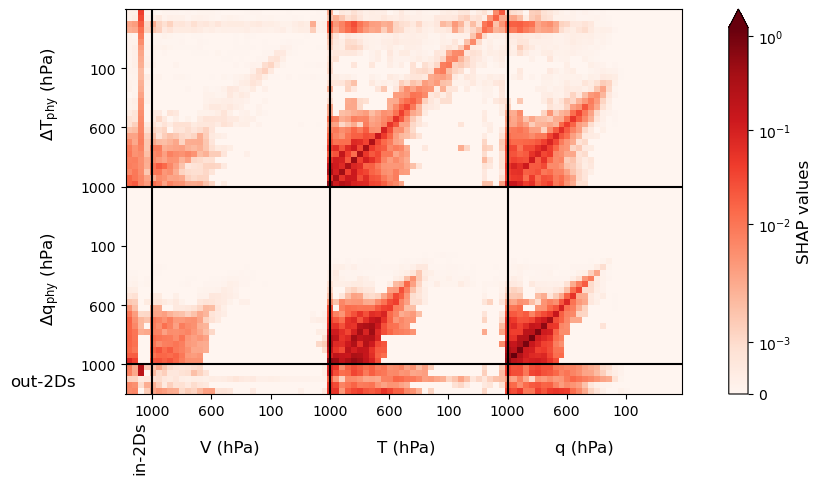

In [96]:
metric = "abs_mean"
shap_matrix_abs_mean, input_inverse_idx2var_abs_mean, output_vars_abs_mean = calculate_shap_matrix(setup, shap_dict_per_var, metric)
fig_abs_mean, ax_abs_mean = plot_matrix_shap("0K", "mask_net_ref2", metric, input_inverse_idx2var_abs_mean, output_vars_abs_mean, shap_matrix_abs_mean, save=output_dir)

plt.savefig(os.path.join(output_dir, "SHAP_values_mask_net_ref2_4K_abs_mean.pdf"), format="pdf", bbox_inches="tight")

fig_abs_mean.show()



Saved Shapley matrix /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_112_mask_net_prediction_thresholds_spars0.001_minus4k_ref2_val/plots_offline_evaluation/shap/range-all_samples-1000_all/plots/SHAP_values_mask_net_ref2_0K_abs_mean_sign.png


FigureCanvasAgg is non-interactive, and thus cannot be shown


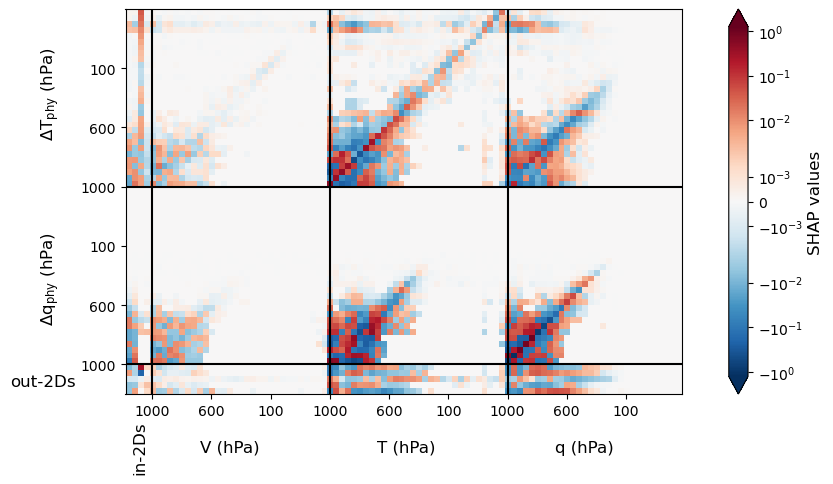

In [97]:
metric = "abs_mean_sign"
shap_matrix_abs_mean_sign, input_inverse_idx2var_abs_mean_sign, output_vars_abs_mean_sign = calculate_shap_matrix(setup, shap_dict_per_var, metric)
fig_abs_mean_sign, ax_abs_mean_sign = plot_matrix_shap("0K", "mask_net_ref2", metric, input_inverse_idx2var_abs_mean_sign, output_vars_abs_mean_sign, shap_matrix_abs_mean_sign, save=output_dir)

plt.savefig(os.path.join(output_dir, "SHAP_values_mask_net_ref2_0K_abs_mean_sign.pdf"), format="pdf", bbox_inches="tight")


fig_abs_mean_sign.show()

## Plot with number of inputs

In [98]:
causal_num_inputs_file = os.path.join(PROJECT_ROOT, "output_castle/eval_nando/causal_single_nn/models_arch-rasp_thrs-opt-mse6", 
                                      "num_inputs_per_var.p")
with open(causal_num_inputs_file, "rb") as read_file:
    causal_num_inputs_per_var = pickle.load(read_file)

print(f"Loading num inputs file {mask_num_inputs_file}")
with open(mask_num_inputs_file, "rb") as read_file:
    mask_num_inputs_per_var = pickle.load(read_file)


Loading num inputs file /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/threshold_performance/num_inputs_per_var_val.p


In [99]:
num_inputs = {"CI-NN": causal_num_inputs_per_var.values(), 
              "MaskNet": mask_num_inputs_per_var.values()}

In [100]:
metric = "abs_mean"
shap_matrix_abs_mean, input_inverse_idx2var_abs_mean, output_vars_abs_mean = calculate_shap_matrix(setup, shap_dict_per_var, metric)


In [101]:
print(output_dir)

/p/scratch/icon-a-ml/kuehbacher1/output_castle/training_112_mask_net_prediction_thresholds_spars0.001_minus4k_ref2_val/plots_offline_evaluation/shap/range-all_samples-1000_all/plots


Saved Shapley matrix /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_112_mask_net_prediction_thresholds_spars0.001_minus4k_ref2_val/plots_offline_evaluation/shap/range-all_samples-1000_all/plots/SHAP_values_mask_net_ref2_0K_abs_mean_num_inputs.png


FigureCanvasAgg is non-interactive, and thus cannot be shown


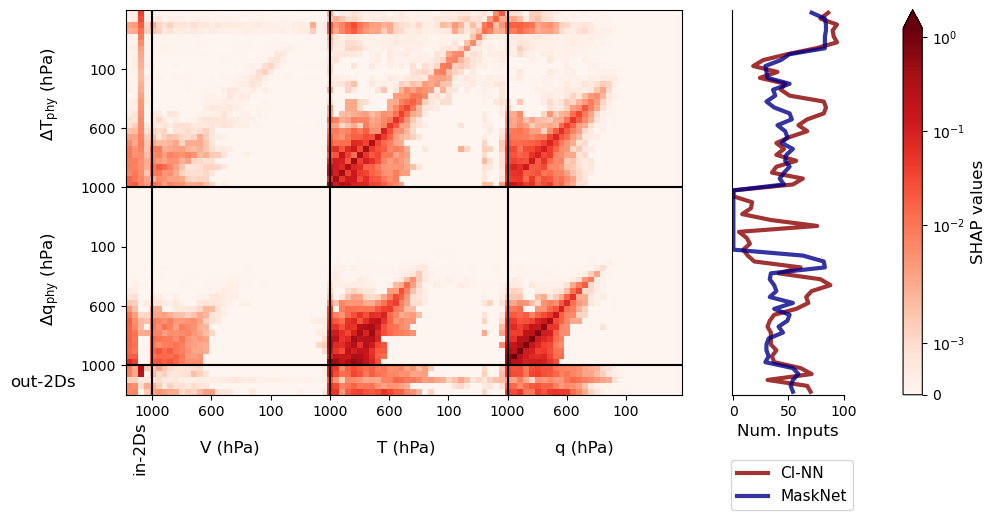

In [102]:
fig_abs_mean, ax_abs_mean = plot_matrix_shap("0K", "mask_net_ref2", metric, input_inverse_idx2var_abs_mean, output_vars_abs_mean, 
                                             shap_matrix_abs_mean, num_parents=num_inputs, save=output_dir)
plt.savefig(os.path.join(output_dir, "SHAP_values_mask_net_ref2_0K_abs_mean_num_inputs.pdf"), format="pdf", bbox_inches="tight")

fig_abs_mean.show()
